In [6]:
import spikeinterface.full as si
from spikeinterface.curation import load_curation, apply_curation
from spikeinterface.sorters import get_default_sorter_params, get_sorter_params_description
import probeinterface as pi
from spikeinterface_gui import run_mainwindow
import numpy as np 
import pandas as pd
from pathlib import Path 
import woodsort.helper_functions as hf 
import pynapple as nap 
import matplotlib.pyplot as plt
import re
import inspect


In [5]:

#paths
recfolder_path ='/home/avadher/SIDB_Datastore/Natalie/4576/4576_251119_R/'

# parameters for probe
shank_groups = [0, 1] # specify which groups in the xml file are shanks (0-base)
probe_manufacturer = "cambridgeneurotech"
probe_name = "ASSY-156-H7" 

# parameters for spike sorting
sorter = "mountainsort5"

# paths 
recfolder_path = Path(recfolder_path)
session_name = recfolder_path.name
processed_folder_name = 'Processed'
spikesorting_folder_name = f"{session_name}_sorting_{sorter}"
spikesorting_path =recfolder_path / spikesorting_folder_name
analyzer_folder_name = f"{session_name}_analyzer_{sorter}"
analyzer_path = recfolder_path / analyzer_folder_name
curation_path = analyzer_path / 'curation.json'


In [3]:
# load xml file to get channel indices

# pick the first xml file in the session 
xml_path = sorted(list(recfolder_path.rglob('continuous.xml')), key=lambda x: int(re.search(r'recording(\d+)', str(x)).group(1)))[0]
xmldata = hf.read_xml(xml_path) # load xml file
xml_channel_indices = np.concatenate(xmldata['anatomical_groups'][shank_groups]) # get channel indices as a single array


Importing metadata from the .xml file...


Probe updated with Neuroscope mapping


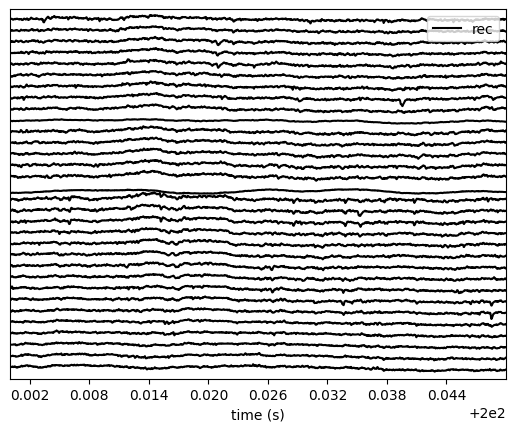

In [5]:
### Load and prepare recording ### 
recording = si.read_openephys(recfolder_path,stream_id='0')
epochs = hf.get_epochs(recording)

# Load probe, check channel number and fill channel indices 
# print(pi.list_all_probes()) # list all available probes 
probe = pi.get_probe(manufacturer=probe_manufacturer, probe_name=probe_name)
probe = hf.add_neuroscope_mapping(probe, xml_channel_indices)

# Process recording for spike sorting  
recording = si.concatenate_recordings([recording])
recording = recording.set_probe(probe, group_mode = 'by_shank')
#si.plot_probe_map(recording, with_device_index=True)
recording = recording.split_by('group')

# Check if the trace looks ok 
si.plot_traces(recording[0], order_channel_by_depth=True, time_range=[200,200.05])
plt.show()

# filter recording
si.set_global_job_kwargs(n_jobs=12) # 
filtered_recording = si.bandpass_filter(recording)
filtered_recording = si.detect_and_remove_bad_channels(filtered_recording)


In [6]:
### Run spike sorting ###
si.set_global_job_kwargs(n_jobs=12) # 
sorting = si.run_sorter(
    recording=filtered_recording, 
    sorter_name=sorter, 
    remove_existing_folder=True, 
    folder=spikesorting_path)


write_binary_recording 
engine=process - n_jobs=12 - samples_per_chunk=30,000 - chunk_memory=3.43 MiB - total_memory=41.20 MiB - chunk_duration=1.00s
Using training recording of duration 300 sec with the sampling mode uniform
*** MS5 Elapsed time for SCHEME2 get_sampled_recording_for_training: 11.153 seconds ***
Running phase 1 sorting
Number of channels: 30
Number of timepoints: 9000000
Sampling frequency: 30000.0 Hz
Channel 0: [  4.5 450. ]
Channel 1: [  6. 600.]
Channel 2: [  2. 200.]
Channel 3: [  7.5 750. ]
Channel 4: [ 0.5 50. ]
Channel 5: [  7. 700.]
Channel 6: [-24.5 475. ]
Channel 7: [-23. 325.]
Channel 8: [-24. 425.]
Channel 9: [-21.5 175. ]
Channel 10: [-25.5 575. ]
Channel 11: [-22. 225.]
Channel 12: [-27. 725.]
Channel 13: [-20.5  75. ]
Channel 14: [-26.5 675. ]
Channel 15: [  1. 100.]
Channel 16: [  2.5 250. ]
Channel 17: [-25. 525.]
Channel 18: [-23.5 375. ]
Channel 19: [-27.5 775. ]
Channel 20: [-21. 125.]
Channel 21: [-26. 625.]
Channel 22: [-22.5 275. ]
Channel 23: [0

In [11]:
### Run analyzer ###

# can't do parallel processing in analyzer on DataStore for some reason - it creates files with weird permissions
job_kwargs = dict(n_jobs=1, chunk_duration="1s", progress_bar=True)

sorting_analyzer = si.create_sorting_analyzer(
    recording=filtered_recording, 
    sorting=sorting, 
    format="binary_folder", 
    folder=analyzer_path,
    overwrite=True)

compute_dict = {'unit_locations': {},
                          'random_spikes': {},
                          'noise_levels': {},
                          'waveforms': {'ms_before':0.8, 'ms_after':1.2},
                          'templates': {},
                          'spike_amplitudes': {},
                          'spike_locations': {},
                          'correlograms': {},
                          'quality_metrics': {},
                          'template_similarity': {},
                          'principal_components': {},
                          'template_metrics': {'include_multi_channel_metrics': True},
                          }

sorting_analyzer.compute(compute_dict, **job_kwargs)



estimate_sparsity (workers: 12 processes):   0%|          | 0/10315 [00:00<?, ?it/s]

compute_waveforms (no parallelization):   0%|          | 0/10315 [00:00<?, ?it/s]

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Fitting PCA:   0%|          | 0/80 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/80 [00:00<?, ?it/s]

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.p

Compute : spike_amplitudes + spike_locations (no parallelization):   0%|          | 0/10315 [00:00<?, ?it/s]

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1505: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  inds_confidence90 = np.row_stack(np.where(conf_matrix[:, test_rp_centers_mask] > 0.9))
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1505: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  inds_confidence90 = np.row_stack(np.where(conf_matrix[:, test_rp_centers_mask] > 0.9))
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1505: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  inds_confidence90 = np.row_stack(np.where(conf_matrix[:, test_rp_centers_mask] > 0.9))
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1505: DeprecationWarning: `row_stack` 

noise_level (workers: 12 processes):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/80 [00:00<?, ?it/s]

In [8]:
analyzer = si.load_sorting_analyzer(analyzer_path)

if curation_path.exists(): 
    curation = load_curation(curation_path)
    analyzer = apply_curation(analyzer, curation_dict_or_model=curation)
    print('Curation applied')
# check for curation and apply it 

run_mainwindow(analyzer, mode="desktop", curation=True)

/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/core/base.py:1123: DeprecationWarning: `recording_list` is deprecated and will be removed in 0.105.0. Please use `recording_list_or_dict` instead.
  extractor = extractor_class(**new_kwargs)
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/postprocessing/template_metrics.py:303: UserWarning: With less than 10 channels, multi-channel metrics might not be reliable.
  warnings.warn(
/home/avadher/.conda/envs/woodsort/lib/python3.10/site-packages/spikeinterface/qualitymetrics/misc_metrics.py:1505: DeprecationWarning: `row_stack` alias is deprecated. Use `np.vstack` directly.
  inds_confidence90 = np.row_stack(np.where(conf_matrix[:, test_rp_centers_mask] > 0.9))
/h

noise_level (no parallelization):   0%|          | 0/20 [00:00<?, ?it/s]

calculate pc_metrics:   0%|          | 0/1 [00:00<?, ?it/s]

Curation applied


In [9]:
# Export to pynapple 

analyzer = si.load_sorting_analyzer(analyzer_path)

if curation_path.exists(): 
    curation = load_curation(curation_path)
    analyzer = apply_curation(analyzer, curation_dict_or_model=curation)
    print('Curation applied')
# check for curation and apply it 

units = hf.export_to_pynapple(
    sorting_analyzer_or_sorting=analyzer, 
    attach_unit_metadata=True
)

print(units)

Index    rate      x          y          z        num_spikes    ...
-------  --------  ---------  ---------  -------  ------------  -----
0        7.48989   23.93879   447.43181  1.0      77254         ...
1        2.75701   24.23031   611.94237  1.0      28437         ...
2        6.05345   0.05848    610.84718  1.0      62438         ...
3        4.43252   2.10976    591.7677   1.0618   45719         ...
4        0.94499   -1.72095   191.91471  1.0      9747          ...
5        2.99473   -10.31764  199.32296  4.83738  30889         ...
6        11.34952  -1.2704    753.58114  1.0      117064        ...
...      ...       ...        ...        ...      ...           ...
74       1.32717   232.84144  178.82289  1.21006  13689         ...
75       3.54008   236.69796  177.62936  8.98377  36514         ...
76       2.23968   239.79668  586.03995  1.06508  23101         ...
77       1.49189   195.9344   556.54178  1.0      15388         ...
78       1.8923    212.24701  576.74093  1.0  